# Portfolio 4 - COMP6200
## Estimation of Obesity Levels Based On Eating Habits and Physical Condition 
* The objective of this portfolio is to answer the following questions:

  1. What model predicts better if a person has obesity?
  2. For Logistic model: which features predicts better if a person has obesity?
  3. For KNN: Which K generates a better model?
  4. Additional: I will search on line how to create a Decision tree model, as we did not make it in tutorials, to understand its performance and as it seems to be a good model for the type of data I choose.
     
* The dataset that was utilized in this portfolio was acquired from the UCI repository, which has 2111 records under 17 features that were collected from Mexico, Peru, and Colombia. The dataset consisted of data based on eating habits and physical conditions. The records were labeled with the class variable NObesitydad, which indicates the level of obesity using seven classifications, which will be the model's target value. The data set was obtained from the following link:

https://archive.ics.uci.edu/dataset/544/estimation+of+obesity+levels+based+on+eating+habits+and+physical+condition
  
* Variable explanation from the dataset:


| Variable Name                  | Type         | Description (Questions to the patients)                                                                
|---------------------------------|--------------|-----------------------------------------------------------------------------|
| Gender                          | Categorical  |                                                                             
| Age                             | Continuous   |                                                                             
| Height                          | Continuous   |                                                                             
| Weight                          | Continuous   |                                                                             
| family_history_with_overweight  | Binary       | Has a family member suffered or suffers from overweight?                    
| FAVC                            | Binary       | Do you eat high caloric food frequently?                                     
| FCVC                            | Integer      | Do you usually eat vegetables in your meals?                                 
| NCP                             | Continuous   | How many main meals do you have daily?                                       
| CAEC                            | Categorical  | Do you eat any food between meals?                                           
| SMOKE                           | Binary       | Do you smoke?                                                               
| CH2O                            | Continuous   | How much water do you drink daily?                                           
| SCC                             | Binary       | Do you monitor the calories you eat daily?                                   
| FAF                             | Continuous   | How often do you have physical activity?                                     
| TUE                             | Integer      | How much time do you use technological devices (e.g., cellphone, videogames)?
| CALC                            | Categorical  | How often do you drink alcohol?                                              
| MTRANS                          | Categorical  | Which transportation do you usually use?                                     
| NObeyesdad                      | Categorical  | Obesity Level calculated with height and weight                                               




In [174]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.feature_selection import RFE
import warnings
warnings.filterwarnings("ignore")

data = pd.read_csv('data/ObesityDataSet_raw_and_data_sinthetic.csv')
data.head()

Gender   Age  Height  Weight family_history_with_overweight FAVC  FCVC  \
0  Female  21.0    1.62    64.0                            yes   no   2.0   
1  Female  21.0    1.52    56.0                            yes   no   3.0   
2    Male  23.0    1.80    77.0                            yes   no   2.0   
3    Male  27.0    1.80    87.0                             no   no   3.0   
4    Male  22.0    1.78    89.8                             no   no   2.0   

   NCP       CAEC SMOKE  CH2O  SCC  FAF  TUE        CALC  \
0  3.0  Sometimes    no   2.0   no  0.0  1.0          no   
1  3.0  Sometimes   yes   3.0  yes  3.0  0.0   Sometimes   
2  3.0  Sometimes    no   2.0   no  2.0  1.0  Frequently   
3  3.0  Sometimes    no   2.0   no  2.0  0.0  Frequently   
4  1.0  Sometimes    no   2.0   no  0.0  0.0   Sometimes   

                  MTRANS           NObeyesdad  
0  Public_Transportation        Normal_Weight  
1  Public_Transportation        Normal_Weight  
2  Public_Transportation        Normal_Weight  
3                Walking   Overweight_Level_I  
4  Public_Transportation  Overweight_Level_II

### 1. Data processing:
First I will check the data and if there are any inconsistencies or missing values.

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          2111 non-null   object 
 1   Age                             2111 non-null   float64
 2   Height                          2111 non-null   float64
 3   Weight                          2111 non-null   float64
 4   family_history_with_overweight  2111 non-null   object 
 5   FAVC                            2111 non-null   object 
 6   FCVC                            2111 non-null   float64
 7   NCP                             2111 non-null   float64
 8   CAEC                            2111 non-null   object 
 9   SMOKE                           2111 non-null   object 
 10  CH2O                            2111 non-null   float64
 11  SCC                             2111 non-null   object 
 12  FAF                             21

In [6]:
# Check unique values per column for object data type:
for i in data.columns:
    if data[i].dtype == object:
        print(data[i].unique())


['Female' 'Male']
['yes' 'no']
['no' 'yes']
['Sometimes' 'Frequently' 'Always' 'no']
['no' 'yes']
['no' 'yes']
['no' 'Sometimes' 'Frequently' 'Always']
['Public_Transportation' 'Walking' 'Automobile' 'Motorbike' 'Bike']
['Normal_Weight' 'Overweight_Level_I' 'Overweight_Level_II'
 'Obesity_Type_I' 'Insufficient_Weight' 'Obesity_Type_II'
 'Obesity_Type_III']


Now I will check if there are any outliers for Age, the only numerical value as I will drop weight and height, features used to calculate the target feature.

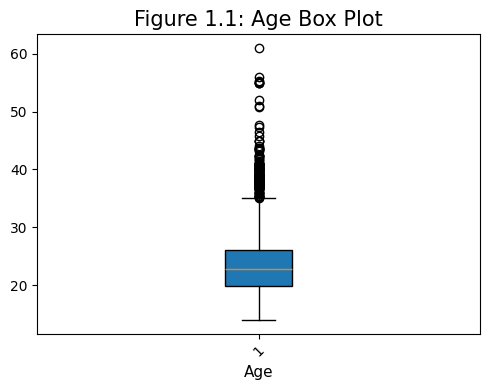

In [8]:
#Plot box plot to understand graphically the outliers
import matplotlib.pyplot as plt
plt.figure(figsize=(5, 4))

plt.boxplot(data['Age'], patch_artist=True)
plt.title('Figure 1.1: Age Box Plot', fontsize=15)
plt.xlabel('Age', fontsize=11)
plt.xticks(rotation=45, fontsize=10);


plt.tight_layout()

I will delete all the outliers as the data has more than 1000 rows which was the recommendation from the professors.

In [10]:
import numpy as np
import pandas as pd

def identify_and_remove_outliers(data, features):
    for feature in features:
        # Calculate the IQR for each feature
        Q1 = data[feature].quantile(0.25)
        Q3 = data[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - IQR
        upper_bound = Q3 + IQR
        
        # Identify how many rows will be dropped
        outliers = data[(data[feature] < lower_bound) | (data[feature] > upper_bound)]
        print(f"{feature}: {len(outliers)} rows will be dropped.")
        
        # Filter the data to remove rows with outliers
        data = data[(data[feature] >= lower_bound) & (data[feature] <= upper_bound)]
    
    return data

# Features to clean
features_to_clean = ['Age']

# Apply the function with an IQR multiplier
data = identify_and_remove_outliers(data, features_to_clean)


Age: 250 rows will be dropped.


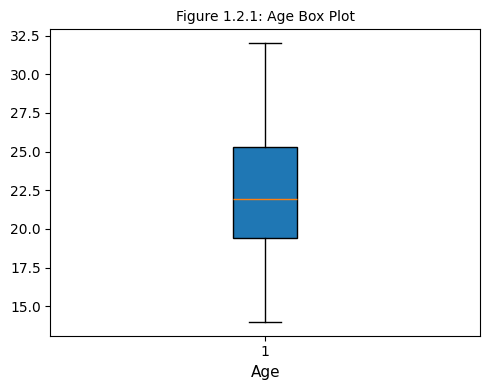

In [11]:
#Plot box plot with remaining rows
import matplotlib.pyplot as plt
plt.figure(figsize=(5, 4))

plt.boxplot(data['Age'], patch_artist=True)
plt.title('Figure 1.2.1: Age Box Plot', fontsize=10)
plt.xlabel('Age', fontsize=11)

plt.tight_layout()

Now I will check the target distribution:

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1861 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          1861 non-null   object 
 1   Age                             1861 non-null   float64
 2   Height                          1861 non-null   float64
 3   Weight                          1861 non-null   float64
 4   family_history_with_overweight  1861 non-null   object 
 5   FAVC                            1861 non-null   object 
 6   FCVC                            1861 non-null   float64
 7   NCP                             1861 non-null   float64
 8   CAEC                            1861 non-null   object 
 9   SMOKE                           1861 non-null   object 
 10  CH2O                            1861 non-null   float64
 11  SCC                             1861 non-null   object 
 12  FAF                             1861 no

I created 2 variables BMI and Obesity bool to try different types of models. In this portfolio, I decided to model the target variable Obesity_Bool, which indicates if the person is obese or not.  

World Health Organization defines as Obese BMI>30 [2]


In [15]:

data['BMI']=data['Weight']/(data['Height']*data['Height']) 
data['Obesity_Bool'] = np.where(data['BMI'] > 29.99, 1, 0)

In [16]:
data = data.drop(columns=['Weight', 'Height'])

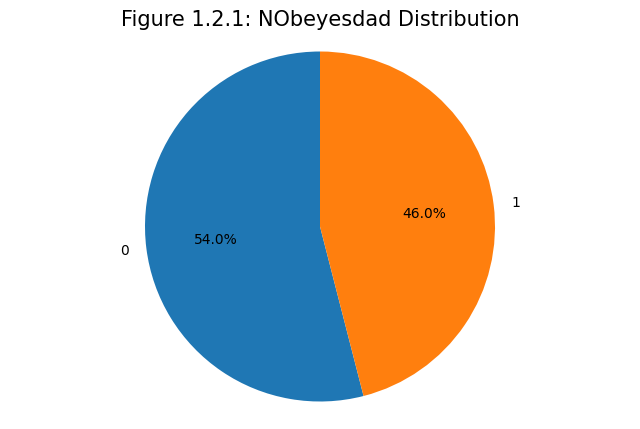

In [17]:
nobeyesdad_counts = data['Obesity_Bool'].value_counts()

# Plot a pie chart
plt.figure(figsize=(8, 5))
plt.pie(nobeyesdad_counts, labels=nobeyesdad_counts.index, autopct='%1.1f%%', startangle=90)

plt.title('Figure 1.2.1: NObeyesdad Distribution', fontsize=15)
plt.axis('equal') 

plt.show()

1. Data processing conclusions:
   1. There are 1861 entries and no missing values
   2. There are 13 features to predict the target value
   3. Height and weight were dropped as they are the variables used to calculate Obesity_Bool.
   4. 250 rows were dropped as they were Age outliers, this was performed with IQR method.
   5. Target data is balanced, as it was synthetically generated by the author. "77% of the data was generated synthetically using the Weka tool and the SMOTE filter, 23% of the data was collected directly from users through a web platform." (UCI Machine Learning Repository, 2019) 
   

### 2. Data Transformation
Now I will transform column names to easier interpret the results and categorical values to make them usable in the models. The steps are:

1. Column name rename
2. Convert variables with two possible outcomes to dummies and then to numbers. Drop one of the result columns.
3. Convert variables with logical order to ordinal encoding
4. Convert Transportation type feature with one hot encoding. Drop one of the columns to avoid multicollinearity. I dropped walking type column.
   

In [20]:
data.head()

Gender   Age family_history_with_overweight FAVC  FCVC  NCP       CAEC  \
0  Female  21.0                            yes   no   2.0  3.0  Sometimes   
1  Female  21.0                            yes   no   3.0  3.0  Sometimes   
2    Male  23.0                            yes   no   2.0  3.0  Sometimes   
3    Male  27.0                             no   no   3.0  3.0  Sometimes   
4    Male  22.0                             no   no   2.0  1.0  Sometimes   

  SMOKE  CH2O  SCC  FAF  TUE        CALC                 MTRANS  \
0    no   2.0   no  0.0  1.0          no  Public_Transportation   
1   yes   3.0  yes  3.0  0.0   Sometimes  Public_Transportation   
2    no   2.0   no  2.0  1.0  Frequently  Public_Transportation   
3    no   2.0   no  2.0  0.0  Frequently                Walking   
4    no   2.0   no  0.0  0.0   Sometimes  Public_Transportation   

            NObeyesdad        BMI  Obesity_Bool  
0        Normal_Weight  24.386526             0  
1        Normal_Weight  24.238227             0  
2        Normal_Weight  23.765432             0  
3   Overweight_Level_I  26.851852             0  
4  Overweight_Level_II  28.342381             0

In [21]:
data = data.rename(columns={'family_history_with_overweight': 'fam_overweight', 'FAVC': 'high_cal_cons','FCVC':'freq_veg','NCP':'num_meals','CAEC':'freq_snack','SCC':'cal_track','FAF':'sport_freq','TUE':'tech_time','CALC':'alc_freq'})


In [22]:
data.head(2)

Gender   Age fam_overweight high_cal_cons  freq_veg  num_meals freq_snack  \
0  Female  21.0            yes            no       2.0        3.0  Sometimes   
1  Female  21.0            yes            no       3.0        3.0  Sometimes   

  SMOKE  CH2O cal_track  sport_freq  tech_time   alc_freq  \
0    no   2.0        no         0.0        1.0         no   
1   yes   3.0       yes         3.0        0.0  Sometimes   

                  MTRANS     NObeyesdad        BMI  Obesity_Bool  
0  Public_Transportation  Normal_Weight  24.386526             0  
1  Public_Transportation  Normal_Weight  24.238227             0

In [23]:

data = pd.get_dummies(data, columns=['Gender', 'fam_overweight','SMOKE','cal_track','high_cal_cons'])


In [24]:

binary_columns = ['Gender_Female', 'Gender_Male', 'fam_overweight_no', 
                  'fam_overweight_yes', 'SMOKE_no', 'SMOKE_yes', 
                  'cal_track_no', 'cal_track_yes','high_cal_cons_yes','high_cal_cons_no']

# Apply the transformation
data[binary_columns] = data[binary_columns].astype(int)

# Print the transformed data
print(data.head())


    Age  freq_veg  num_meals freq_snack  CH2O  sport_freq  tech_time  \
0  21.0       2.0        3.0  Sometimes   2.0         0.0        1.0   
1  21.0       3.0        3.0  Sometimes   3.0         3.0        0.0   
2  23.0       2.0        3.0  Sometimes   2.0         2.0        1.0   
3  27.0       3.0        3.0  Sometimes   2.0         2.0        0.0   
4  22.0       2.0        1.0  Sometimes   2.0         0.0        0.0   

     alc_freq                 MTRANS           NObeyesdad  ...  Gender_Female  \
0          no  Public_Transportation        Normal_Weight  ...              1   
1   Sometimes  Public_Transportation        Normal_Weight  ...              1   
2  Frequently  Public_Transportation        Normal_Weight  ...              0   
3  Frequently                Walking   Overweight_Level_I  ...              0   
4   Sometimes  Public_Transportation  Overweight_Level_II  ...              0   

   Gender_Male  fam_overweight_no  fam_overweight_yes  SMOKE_no  SMOKE_yes  \
0 

Now I will transform ordinal values

In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1861 entries, 0 to 2110
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Age                 1861 non-null   float64
 1   freq_veg            1861 non-null   float64
 2   num_meals           1861 non-null   float64
 3   freq_snack          1861 non-null   object 
 4   CH2O                1861 non-null   float64
 5   sport_freq          1861 non-null   float64
 6   tech_time           1861 non-null   float64
 7   alc_freq            1861 non-null   object 
 8   MTRANS              1861 non-null   object 
 9   NObeyesdad          1861 non-null   object 
 10  BMI                 1861 non-null   float64
 11  Obesity_Bool        1861 non-null   int32  
 12  Gender_Female       1861 non-null   int32  
 13  Gender_Male         1861 non-null   int32  
 14  fam_overweight_no   1861 non-null   int32  
 15  fam_overweight_yes  1861 non-null   int32  
 16  SMOKE_no   

In [27]:
freq_mapping = {
    'no':0,
    'Sometimes':1,
    'Frequently':2,
    'Always':3
}

# Apply the mapping to the 'Satisfaction_Level' column
data['freq_snack_encoded'] = data['freq_snack'].map(freq_mapping)
data['alc_freq_encoded'] = data['alc_freq'].map(freq_mapping)

print(data)

            Age  freq_veg  num_meals freq_snack      CH2O  sport_freq  \
0     21.000000       2.0        3.0  Sometimes  2.000000    0.000000   
1     21.000000       3.0        3.0  Sometimes  3.000000    3.000000   
2     23.000000       2.0        3.0  Sometimes  2.000000    2.000000   
3     27.000000       3.0        3.0  Sometimes  2.000000    2.000000   
4     22.000000       2.0        1.0  Sometimes  2.000000    0.000000   
...         ...       ...        ...        ...       ...         ...   
2106  20.976842       3.0        3.0  Sometimes  1.728139    1.676269   
2107  21.982942       3.0        3.0  Sometimes  2.005130    1.341390   
2108  22.524036       3.0        3.0  Sometimes  2.054193    1.414209   
2109  24.361936       3.0        3.0  Sometimes  2.852339    1.139107   
2110  23.664709       3.0        3.0  Sometimes  2.863513    1.026452   

      tech_time    alc_freq                 MTRANS           NObeyesdad  ...  \
0      1.000000          no  Public_Transpo

In [28]:
for i in data.columns:
    if data[i].dtype == object:
        print(data[i].unique())


['Sometimes' 'Frequently' 'Always' 'no']
['no' 'Sometimes' 'Frequently' 'Always']
['Public_Transportation' 'Walking' 'Automobile' 'Motorbike' 'Bike']
['Normal_Weight' 'Overweight_Level_I' 'Overweight_Level_II'
 'Obesity_Type_I' 'Insufficient_Weight' 'Obesity_Type_II'
 'Obesity_Type_III']


Now I will transform transportation with one hot encoding

In [30]:
one_hot_encoded_df = pd.get_dummies(data['MTRANS'], prefix='MTRANS')
one_hot_encoded_df = one_hot_encoded_df.astype(int)
data=pd.concat([data, one_hot_encoded_df], axis=1)

now I will drop columns to avoid multicolinearity and duplicate features. For MTRANS as I transformed it with one hot encoding I will drop one column to avoid multicollinearity

In [32]:
print(data.columns)

Index(['Age', 'freq_veg', 'num_meals', 'freq_snack', 'CH2O', 'sport_freq',
       'tech_time', 'alc_freq', 'MTRANS', 'NObeyesdad', 'BMI', 'Obesity_Bool',
       'Gender_Female', 'Gender_Male', 'fam_overweight_no',
       'fam_overweight_yes', 'SMOKE_no', 'SMOKE_yes', 'cal_track_no',
       'cal_track_yes', 'high_cal_cons_no', 'high_cal_cons_yes',
       'freq_snack_encoded', 'alc_freq_encoded', 'MTRANS_Automobile',
       'MTRANS_Bike', 'MTRANS_Motorbike', 'MTRANS_Public_Transportation',
       'MTRANS_Walking'],
      dtype='object')


In [33]:

data = data.drop(columns=['freq_snack', 'MTRANS','alc_freq','fam_overweight_no','Gender_Male','SMOKE_no',
                        'cal_track_no', 'high_cal_cons_no','BMI','NObeyesdad'])
data1=data.copy() # to use it later for decision tree model
data = data.drop(columns=['MTRANS_Walking'])

data.head()

Age  freq_veg  num_meals  CH2O  sport_freq  tech_time  Obesity_Bool  \
0  21.0       2.0        3.0   2.0         0.0        1.0             0   
1  21.0       3.0        3.0   3.0         3.0        0.0             0   
2  23.0       2.0        3.0   2.0         2.0        1.0             0   
3  27.0       3.0        3.0   2.0         2.0        0.0             0   
4  22.0       2.0        1.0   2.0         0.0        0.0             0   

   Gender_Female  fam_overweight_yes  SMOKE_yes  cal_track_yes  \
0              1                   1          0              0   
1              1                   1          1              1   
2              0                   1          0              0   
3              0                   0          0              0   
4              0                   0          0              0   

   high_cal_cons_yes  freq_snack_encoded  alc_freq_encoded  MTRANS_Automobile  \
0                  0                   1                 0                  0   
1                  0                   1                 1                  0   
2                  0                   1                 2                  0   
3                  0                   1                 2                  0   
4                  0                   1                 1                  0   

   MTRANS_Bike  MTRANS_Motorbike  MTRANS_Public_Transportation  
0            0                 0                             1  
1            0                 0                             1  
2            0                 0                             1  
3            0                 0                             0  
4            0                 0                             1

## 3. Modelling

### 3.1 Logistic Regression
First I will perform a Logistic Regression as the target variable is discrete,

In [36]:
# Getting input data and targets for building prediction model and standardize the data for all models.
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score

X = data.drop(['Obesity_Bool'], axis=1)
y = data['Obesity_Bool']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=1)

print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)


X_train shape:  (1488, 17)
y_train shape:  (1488,)
X_test shape:  (373, 17)
y_test shape:  (373,)


First, I will check the correlation of the features with the target value.

In [38]:
correlation_matrix=data.corr()
correlation_with_target = correlation_matrix['Obesity_Bool'].sort_values(ascending=False)

correlation_with_target

Obesity_Bool                    1.000000
fam_overweight_yes              0.434465
Age                             0.386491
high_cal_cons_yes               0.279179
freq_veg                        0.215744
CH2O                            0.133332
MTRANS_Public_Transportation    0.099377
num_meals                       0.050510
alc_freq_encoded                0.047790
SMOKE_yes                       0.019220
Gender_Female                   0.016368
MTRANS_Automobile              -0.023780
MTRANS_Motorbike               -0.048795
MTRANS_Bike                    -0.052488
tech_time                      -0.065592
sport_freq                     -0.165807
cal_track_yes                  -0.195546
freq_snack_encoded             -0.241842
Name: Obesity_Bool, dtype: float64

From correlation matrix for Target value I can see that the features with greater correlation are:
1. Family member with overweight (0.43): If the person has a family member with obesity is more probable that she/he will have obesity.
2. Age(0.39): as age increases is more likely that the person has obesity.
3. high_cal_cons_yes (0.28): If the person consumes high calory food is more likely to have obesity.
4. freq_snack_encoded (-0.24): This negative correlation indicates that as the person eats more snacks or food between meals, is less likely they will have obesity.


In [40]:
# Training Logistic Regression model

model = LogisticRegression()

# Fit the model
model.fit(X_train, y_train)

# Predict the target for test data

model.fit(X_train, y_train)

LogisticRegression()

In [41]:
# Doing predictions on train and test set
y_hat_train = model.predict(X_train)
y_hat_test = model.predict(X_test)

In [42]:
# Evaluate the performance of your trained model
print("Accuracy score on training set: ", accuracy_score(y_train, y_hat_train))
print("Accuracy score on testing set: ", accuracy_score(y_test, y_hat_test))
print("F1 Score on testing set: ", f1_score(y_test, y_hat_test))

Accuracy score on training set:  0.8138440860215054
Accuracy score on testing set:  0.7774798927613941
F1 Score on testing set:  0.7726027397260274


The accuracy score for testing set is 0.78. Also, there is a very small gap in the accuracy scores for training and testing set, so there is no overfitting of the model

In [44]:
# Checking confusion matrix
print("Confusion matrix on test set: ")
print(confusion_matrix(y_test, y_hat_test))

Confusion matrix on test set: 
[[149  48]
 [ 35 141]]


From the confusion matrix, I can identify the following:

1. **Diagonal elements**: These represent the correct classifications for each class. 149 class 0 were correctly identified and 141 class 1 were correctly identified. --> 78% of the test data was correctly identified by the logistic model.

2. **Misclassification**: 
   - 35 values that were class 1 were identified as class 0 and 48 class 0 as class 1.


### 3.1.2 RFE
I will find the best features to avoid the curse of dimensionality.

In [47]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

model = LogisticRegression()
acc_scores = []

for i in range(1, 18):  # 17 features
    rfe = RFE(estimator=model, n_features_to_select=i)
    rfe.fit(X_train, y_train)
    y_pred = rfe.predict(X_test)
    acc_score = accuracy_score(y_test, y_pred)
    print(f"Acc on test set using {i} features: {acc_score}")
    acc_scores.append(acc_score)


Acc on test set using 1 features: 0.6487935656836461
Acc on test set using 2 features: 0.6863270777479893
Acc on test set using 3 features: 0.7265415549597856
Acc on test set using 4 features: 0.7828418230563002
Acc on test set using 5 features: 0.7453083109919572
Acc on test set using 6 features: 0.7506702412868632
Acc on test set using 7 features: 0.774798927613941
Acc on test set using 8 features: 0.774798927613941
Acc on test set using 9 features: 0.774798927613941
Acc on test set using 10 features: 0.7667560321715817
Acc on test set using 11 features: 0.7855227882037533
Acc on test set using 12 features: 0.7908847184986595
Acc on test set using 13 features: 0.7828418230563002
Acc on test set using 14 features: 0.7828418230563002
Acc on test set using 15 features: 0.7882037533512064
Acc on test set using 16 features: 0.7801608579088471
Acc on test set using 17 features: 0.7774798927613941


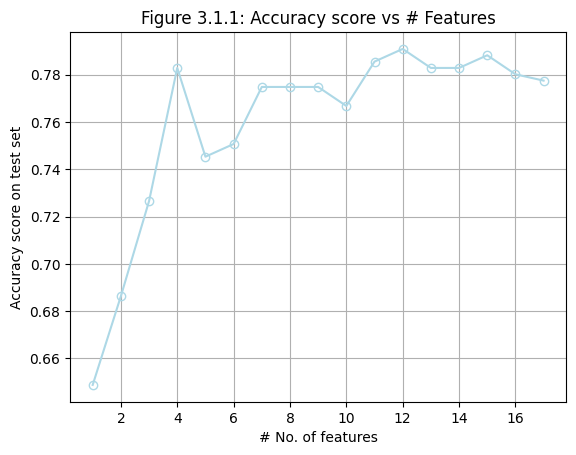

In [48]:
# Estimating accuracy score on test set using RFE by using different number of features. Then plot the results
estimator = LogisticRegression()
acc_scores = []
for i in range(1, 18):
    selector = RFE(estimator,n_features_to_select=i)
    selector = selector.fit(X_train, y_train)
    supp = selector.get_support()

    predicted = selector.predict(X_test)
    acc_score = accuracy_score(y_test, predicted)
    acc_scores.append(acc_score)



plt.grid()
plt.title("Figure 3.1.1: Accuracy score vs # Features")
plt.xlabel('# No. of features')
plt.ylabel('Accuracy score on test set')
plt.plot(range(1, 18), acc_scores, marker = 'o', color = 'lightblue', markeredgewidth = 1 ,markeredgecolor = 'lightblue', markerfacecolor = 'None')

plt.show()

In [49]:
#Show the selected features and f1 score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

selector = RFE(estimator, n_features_to_select=12)  # select 12 features for us
selector = selector.fit(X_scaled, y)

feature_cols = ['Age', 'freq_veg', 'num_meals', 'CH2O', 'sport_freq', 
                'tech_time', 'Gender_Female', 'fam_overweight_yes', 
                'SMOKE_yes', 'cal_track_yes', 'high_cal_cons_yes', 
                'freq_snack_encoded', 'alc_freq_encoded', 
                'MTRANS_Automobile', 'MTRANS_Bike', 
                'MTRANS_Motorbike', 'MTRANS_Public_Transportation']


supp = selector.get_support()  

selected_features = np.array(feature_cols)[supp]
print("Selected features:", selected_features)


print("Coeffs:", selector.estimator_.coef_)

# Test the model 
predicted = selector.predict(X_test) 
f1_score = f1_score(y_test, predicted)
print("f1 Score",f1_score)

Selected features: ['Age' 'freq_veg' 'CH2O' 'sport_freq' 'fam_overweight_yes' 'SMOKE_yes'
 'cal_track_yes' 'high_cal_cons_yes' 'freq_snack_encoded'
 'alc_freq_encoded' 'MTRANS_Automobile' 'MTRANS_Public_Transportation']
Coeffs: [[ 0.81747365  0.62713142  0.22785129 -0.25701663  1.52941446  0.12129094
  -0.50895326  0.71267387 -0.81027967 -0.31588475  0.21089845  0.69407281]]
f1 Score 0.7880434782608695


.


#### For the Logistic Regression model the key findings are as follows:

1. No overfitting was observed in the model as the accuracy for train and test data set were close.
2. The accuracy of the test data is 0.78 with all the features available and F1 score= 0.77
3. Out of the 373 instances in the test data, 290 were correctly classified.
4. After performing RFE, the best model is built with the following 12 features:
   * 'Age' 'freq_veg' 'CH2O' 'sport_freq' 'fam_overweight_yes' 'SMOKE_yes'
 'cal_track_yes' 'high_cal_cons_yes' 'freq_snack_encoded'
 'alc_freq_encoded' 'MTRANS_Automobile' 'MTRANS_Public_Transportation'
5. With 12 features the accuracy increases to 0.79 and F1 Score= 0.79

Next, I will create additional models to compare the results.


### 3.2 KNN Classifier

K=1, Training Accuracy: 1.0000, Testing Accuracy: 0.8981
K=2, Training Accuracy: 0.9698, Testing Accuracy: 0.8954
K=3, Training Accuracy: 0.9550, Testing Accuracy: 0.9008
K=4, Training Accuracy: 0.9516, Testing Accuracy: 0.8981
K=5, Training Accuracy: 0.9388, Testing Accuracy: 0.8901
K=6, Training Accuracy: 0.9375, Testing Accuracy: 0.8767
K=7, Training Accuracy: 0.9234, Testing Accuracy: 0.8740
K=8, Training Accuracy: 0.9220, Testing Accuracy: 0.8606
K=9, Training Accuracy: 0.9167, Testing Accuracy: 0.8633
K=10, Training Accuracy: 0.9187, Testing Accuracy: 0.8660
K=11, Training Accuracy: 0.9079, Testing Accuracy: 0.8606
K=12, Training Accuracy: 0.9126, Testing Accuracy: 0.8552
K=13, Training Accuracy: 0.8972, Testing Accuracy: 0.8606
K=14, Training Accuracy: 0.9039, Testing Accuracy: 0.8579
K=15, Training Accuracy: 0.8985, Testing Accuracy: 0.8579
K=16, Training Accuracy: 0.9012, Testing Accuracy: 0.8525
K=17, Training Accuracy: 0.8911, Testing Accuracy: 0.8525
K=18, Training Accuracy

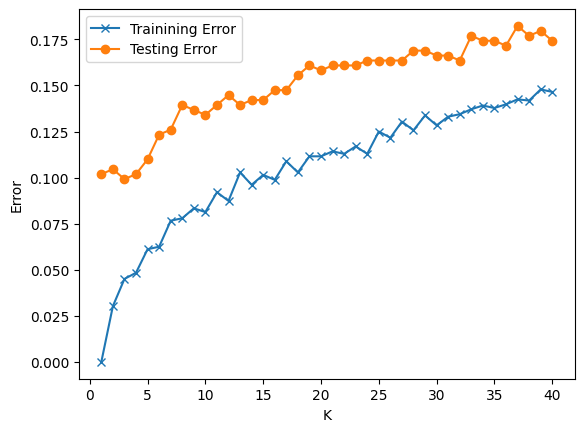

In [53]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
# Plot the accurcy trend w.r.t. K
training_error=list()
testing_error=list()

# I will loop the model for 40 values to understand if at some point the model gets better increasing K

for i in range(1, 41): 
    clf = KNeighborsClassifier(n_neighbors = i)
    clf.fit(X_train, y_train)
    train_acc = accuracy_score(y_train, clf.predict(X_train))
    test_acc = accuracy_score(y_test, clf.predict(X_test))
    training_error.append(1.0-accuracy_score(clf.predict(X_train), y_train))
    testing_error.append(1.0-accuracy_score(clf.predict(X_test), y_test))
    
    
    print(f"K={i}, Training Accuracy: {train_acc:.4f}, Testing Accuracy: {test_acc:.4f}")

# Plot the relationship
plt.plot(range(1, 41), training_error, marker='x', label='Trainining Error')
plt.plot(range(1, 41), testing_error, marker='o', label='Testing Error')
plt.xlabel('K')
plt.ylabel('Error')
plt.legend(loc='best')
plt.show()

In [54]:
# Define search space for parameters
from sklearn.model_selection import cross_val_score, KFold

cv_scores_std=[]
cv_scores=[]
k_range=range(1,50)
param_grid=dict(n_neighbors=k_range)
grid=GridSearchCV(clf,param_grid,scoring='accuracy',cv=KFold(n_splits=10,shuffle=True))
clf= KNeighborsClassifier()
grid.fit(X_scaled, y)

print(grid.best_params_)
print(grid.best_score_)
print(grid.best_estimator_)




{'n_neighbors': 2}
0.9210079926398711
KNeighborsClassifier(n_neighbors=2)


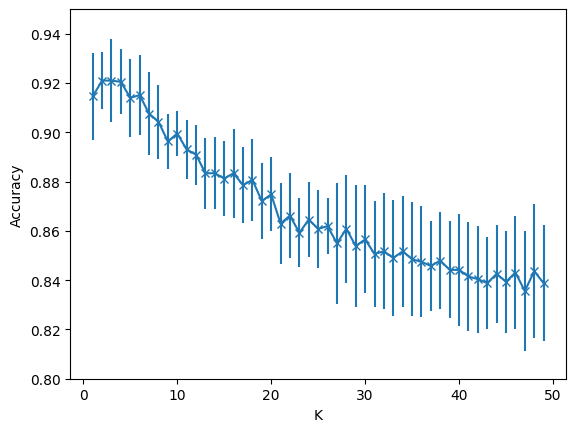

In [55]:
cv_scores_mean=grid.cv_results_['mean_test_score']
cv_scores_std=grid.cv_results_['std_test_score']
plt.errorbar(k_range,cv_scores_mean,yerr=cv_scores_std,marker='x',label='Accuracy')
plt.ylim([0.8,0.95])
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.show()

In [56]:
# Now I will calculate the F1 Score to compare it with the previous model
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

#Now I will run again the model with the data splitted and the best K founded before (K=4)
best_k = 4
knn_clf_best = KNeighborsClassifier(n_neighbors=best_k)
knn_clf_best.fit(X_train, y_train)

#Calculate the prediction
y_pred = knn_clf_best.predict(X_test)
f1_score = f1_score(y_test, y_pred)
print('F1 Score: ', f1_score)

F1 Score:  0.8926553672316384


In [57]:
print("Confusion matrix on test set: ")
print(confusion_matrix(y_test, y_pred))

Confusion matrix on test set: 
[[177  20]
 [ 18 158]]


#### KNN Classifier Findings:
1. Initial Model Evaluation: 
   I first trained the KNN model using the train-test split approach, which identified the best value of K = 3. The model achieved a Training Accuracy of 0.96 and a Testing Accuracy of 0.90, indicating minimal overfitting as the training and testing accuracies are close.

2. Cross-Validation for Robustness: 
   To ensure the model’s robustness and use all available data, I applied 10-fold cross-validation. The best ( K ) selected through cross-validation was ( K = 4 ), with a mean accuracy of 0.92, suggesting consistent performance across different subsets of data.

3. Model Performance: 
   For the best model ( K = 4 ), 335 out of 373 instances were correctly classified, resulting in an F1 score of 0.89. This indicates a balanced performance in terms of precision and recall.

4. Comparison with Logistic Regression: 
   The KNN classifier outperforms the logistic regression model, improving accuracy from 0.78 to 0.92 and F1 score from 0.77 to 0.89. This highlights the effectiveness of KNN for this particular dataset and task.


Now I will make a decision tree model to compare with the other models.

In [60]:

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# I will use the data without standardization for better interpretation and as it is not necessary for this model.
X = data1.drop(['Obesity_Bool'], axis=1)
y = data1['Obesity_Bool']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

model = DecisionTreeClassifier(criterion='entropy', max_depth=4, random_state=1) # 4 leafs

#Train model
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

# Confusion matrix and classification report for detailed performance analysis
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.8070
Confusion Matrix:
 [[156  41]
 [ 31 145]]
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.79      0.81       197
           1       0.78      0.82      0.80       176

    accuracy                           0.81       373
   macro avg       0.81      0.81      0.81       373
weighted avg       0.81      0.81      0.81       373



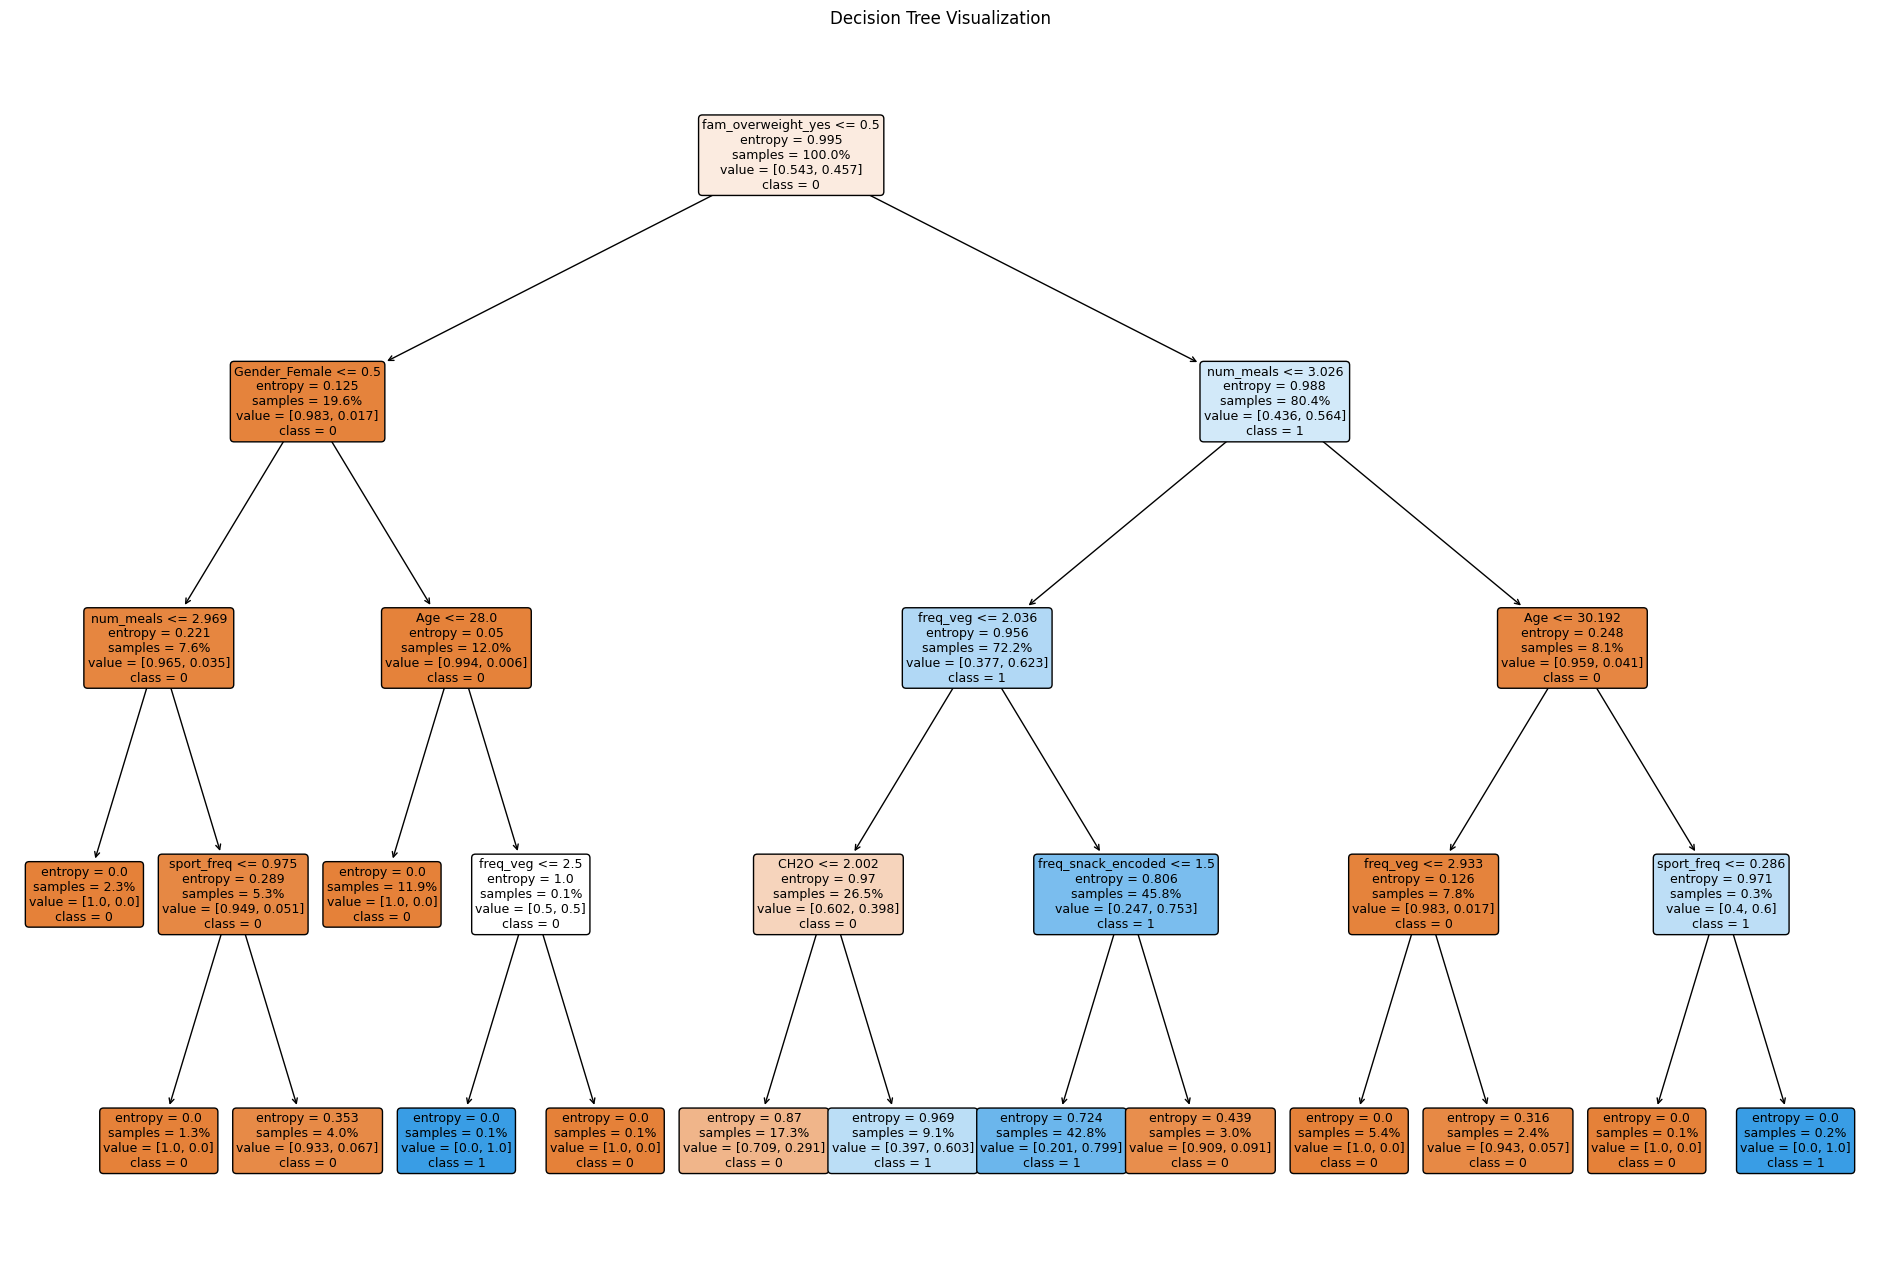

In [61]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
#Now I will plot the model:
feature_names = X.columns.tolist()  # List of feature names
target_names = data1['Obesity_Bool'].unique().astype(str).tolist()  # List of unique target labels

plt.figure(figsize=(24, 16))

plot_tree(
    model, 
    feature_names=feature_names, 
    class_names=target_names, 
    filled=True,            # Colors the nodes based on class probabilities
    fontsize=9,             # Adjust fontsize for readability
    proportion=True,        # Proportional node sizes based on sample count
    rounded=True            
)

plt.title("Decision Tree Visualization")
plt.show()


#### Decision Tree Model Findings:
1. Accuracy: The model achieved an accuracy of 0.81.

2. F1 Score: The F1 score for the model is 0.81, indicating balanced performance.

3. Overall Performance: The decision tree model demonstrates good overall performance with balanced precision, recall, and F1 scores across both classes. However, the confusion matrix indicates that the model is slightly more accurate in predicting negative instances (class 0) compared to positive instances (class 1).

4. Interpretability: The decision tree plot provides clear insights into how different feature values influence classifications for obesity, making the model easier to interpret.

5. Entropy Measurement: When the leaf node has an entropy close to 0, it indicates that the node is "pure," meaning that most samples belong to one class.

6. Example Interpretation: For instance, if a person does not have a family history of overweight (<= 0.5) and is female (Gender_Female <= 0.5), the decision tree predicts that they are not obese (class 0). This prediction is supported by the fact that 98.3% of the samples in this subset are classified as not obese.

7. Model Comparison: This model shows better performance than the logistic regression model but performs worse than the KNN model.

## Final Conclusions from the Findings:
1. **Model Performance Comparison**:

    1. KNN Classifier: This model achieved the highest accuracy (0.92) and F1 score (0.89), making it the best performing model among the three. It shows that KNN effectively captures the complexities in the dataset and is suitable for predicting obesity.
    2. Decision Tree Model: With an accuracy of 0.81 and an F1 score of 0.81, the Decision Tree offers good interpretability and performance but falls short compared to KNN. It effectively identifies patterns, especially in negative cases (non-obese), but may require further tuning for improved performance.
    3. Logistic Regression: Although this model shows reasonable performance with an accuracy of 0.78 and an F1 score of 0.77, it is outperformed by both KNN and Decision Trees. The performance gap suggests that the linear assumptions of logistic regression may not capture the relationships present in the data.

2. **Feature Importance**:

For the Logistic Regression model, I identified that the RFE process highlighted specific features that contribute most to predicting obesity, indicating that certain variables significantly influence the likelihood of obesity.
This insight can guide further investigations into which factors should be targeted for interventions or public health strategies.

3. **Model Interpretability**:
The Decision Tree provides intuitive visualizations that facilitate understanding of how features impact predictions. The entropy measures can help in identifying the purity of nodes, allowing for better interpretability and communication of results.


4. **What model predicts better if a person has obesity?**

The KNN classifier predicts better, as evidenced by its higher accuracy (0.92) and F1 score (0.89). This indicates that KNN is more reliable in identifying instances of obesity compared to the other models.
For the Logistic model: which features predict better if a person has obesity?

5. **The features identified by RFE that contribute to the Logistic Regression model include:**
'Age'
'freq_veg'
'CH2O'
'sport_freq'
'fam_overweight_yes'
'SMOKE_yes'
'cal_track_yes'
'high_cal_cons_yes'
'freq_snack_encoded'
'alc_freq_encoded'
'MTRANS_Automobile'
'MTRANS_Public_Transportation'
These features can provide insights into potential risk factors associated with obesity.

6. **For KNN: Which K generates a better model?**

The optimal value of K is determined through cross-validation. K = 4 yielded the best performance with an accuracy of 0.92, making it the ideal choice for this dataset.


## References:
1. Estimation of Obesity Levels Based On Eating Habits and Physical Condition  [Dataset]. (2019). UCI Machine Learning Repository. https://doi.org/10.24432/C5H31Z.
2. World Health Organization. (n.d.). Obesity. https://www.who.int/health-topics/noncommunicable-diseases/obesity#tab=tab_1